# Introduction

Our dataset, Student Alcohol Consumption, contains information about the lives of students from two secondary schools in Portugal. The variables span the various facets of their lives- social, educational, home life and other details such as age, health status and gender. 

It also contains data measuring the students' weekday and weekend alcohol consumption levels. 

### Problem Statement:
We decided to use the students' data to predict their alcohol consumption habits. From this, we hope to find the factors of a student's life that serve as the best indicators of alcoholism.

### Why we chose this problem: 
Alcoholism is a serious issue, and from finding indicators of alcoholic tendencies in students (high alcohol consumption), we could use it in the real world to single out students that are at high risk of alcohol dependency, and intervene.

In [59]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics


sb.set_theme() # set the default Seaborn style for graphics

In [60]:
students1 = pd.read_csv('archive/student-mat.csv')
students1.dataframeName = 'archive/student-mat.csv'
students2 = pd.read_csv('archive/student-por.csv')

# Data Cleanup

Two dataframes were given, one for students in the Math course and one for students in the Portugese language course. Some students are in both courses, and some are only in one, so we combined the dataframes and removed the duplicates.

1. Merge dataframes and remove duplicates.

2. The original dataset has two columns to measure alcohol consumption, ‘Dalc’ (weekday consumption) and ‘Walc’ (weekend consumption), scale of 1 to 5.  Here we combine them to one column ‘alc’ with values 0 (low general consumption) and 1 (high general consumption).

3. One-hot encode categorical variables that are 'object' types.


data-description.txt

    school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
    sex - student's sex (binary: 'F' - female or 'M' - male)
    age - student's age (numeric: from 15 to 22)
    address - student's home address type (binary: 'U' - urban or 'R' - rural)
    famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
    Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
    Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
    Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
    Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
    Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
    reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
    guardian - student's guardian (nominal: 'mother', 'father' or 'other')
    traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
    studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
    failures - number of past class failures (numeric: n if 1<=n<3, else 4)
    schoolsup - extra educational support (binary: yes or no)
    famsup - family educational support (binary: yes or no)
    paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
    activities - extra-curricular activities (binary: yes or no)
    nursery - attended nursery school (binary: yes or no)
    higher - wants to take higher education (binary: yes or no)
    internet - Internet access at home (binary: yes or no)
    romantic - with a romantic relationship (binary: yes or no)
    famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
    freetime - free time after school (numeric: from 1 - very low to 5 - very high)
    goout - going out with friends (numeric: from 1 - very low to 5 - very high)
    Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
    Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
    health - current health status (numeric: from 1 - very bad to 5 - very good)
    absences - number of school absences (numeric: from 0 to 93)

In [61]:
# merging dataframes
# #G1, G2 and G3 are the students' grades for that specific course. they stop us from removing 
# the duplicated students, and we are not using grades as predictors so we remove them.
students1_new = students1.drop(columns = ['G1','G2','G3']) 
students2_new = students2.drop(columns = ['G1','G2','G3'])
students = pd.concat([students1_new, students2_new], axis=0)
students.info()



<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 0 to 648
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher      10

In [62]:
students = students.drop_duplicates(ignore_index= True)

students['id'] = range(1, len(students) + 1)
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,id
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,4
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,5


In [63]:
# replace Dalc and Walc with alc
dictionary = {}
for i in range(len(students)):
    dalc = students.at[i, "Dalc"]
    walc = students.at[i, "Walc"]
    if (dalc >= 4 or walc >= 4):
        dictionary[i] = 1
    else:
        dictionary[i] = 0


dictionary = {}
for i, row in students.iterrows():
    dalc = row["Dalc"]
    walc = row["Walc"]
    if (dalc >= 4 or walc >= 4):
        dictionary[i] = 1
    else:
        dictionary[i] = 0
    
students['alc'] = 0  # initialize the new column with default values

for i in range(len(students)):
    if (students.iloc[i]['Dalc'] >= 4 or students.iloc[i]['Walc'] >= 4):
        students.at[i, 'alc'] = 1
    else:
        students.at[i, 'alc'] = 0

# one hot encoding

# duplicate students dataframe - students1 will be used for one hot encoding
students1 = students.copy()
students1.drop(['Dalc', 'Walc'], axis=1, inplace=True) # remove dalc and walc columns and modify DataFrame

# one hot encode the object-dtype columns with sklearn LabelEncoder
categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    students1[col] = label_encoders[col].fit_transform(students[col])

students1.head(20)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,health,absences,id,alc
0,0,0,18,1,0,0,4,4,0,4,...,1,0,0,4,3,4,3,6,1,0
1,0,0,17,1,0,1,1,1,0,2,...,1,1,0,5,3,3,3,4,2,0
2,0,0,15,1,1,1,1,1,0,2,...,1,1,0,4,3,2,3,10,3,0
3,0,0,15,1,0,1,4,2,1,3,...,1,1,1,3,2,2,5,2,4,0
4,0,0,16,1,0,1,3,3,2,2,...,1,0,0,4,3,2,5,4,5,0
5,0,1,16,1,1,1,4,3,3,2,...,1,1,0,5,4,2,5,10,6,0
6,0,1,16,1,1,1,2,2,2,2,...,1,1,0,4,4,4,3,0,7,0
7,0,0,17,1,0,0,4,4,2,4,...,1,0,0,4,1,4,1,6,8,0
8,0,1,15,1,1,0,3,2,3,2,...,1,1,0,4,2,2,1,0,9,0
9,0,1,15,1,0,1,3,4,2,2,...,1,1,0,5,5,1,5,0,10,0


# Date Exploration

Visualise the data distributions and the relationship between the variables, using correlation, and the chi-square test.

We have 28 predictor columns and want to choose a few best columns for predicting. So we separated the columns into types of variables- family-related, education-related, character-related and lifestyle-related.

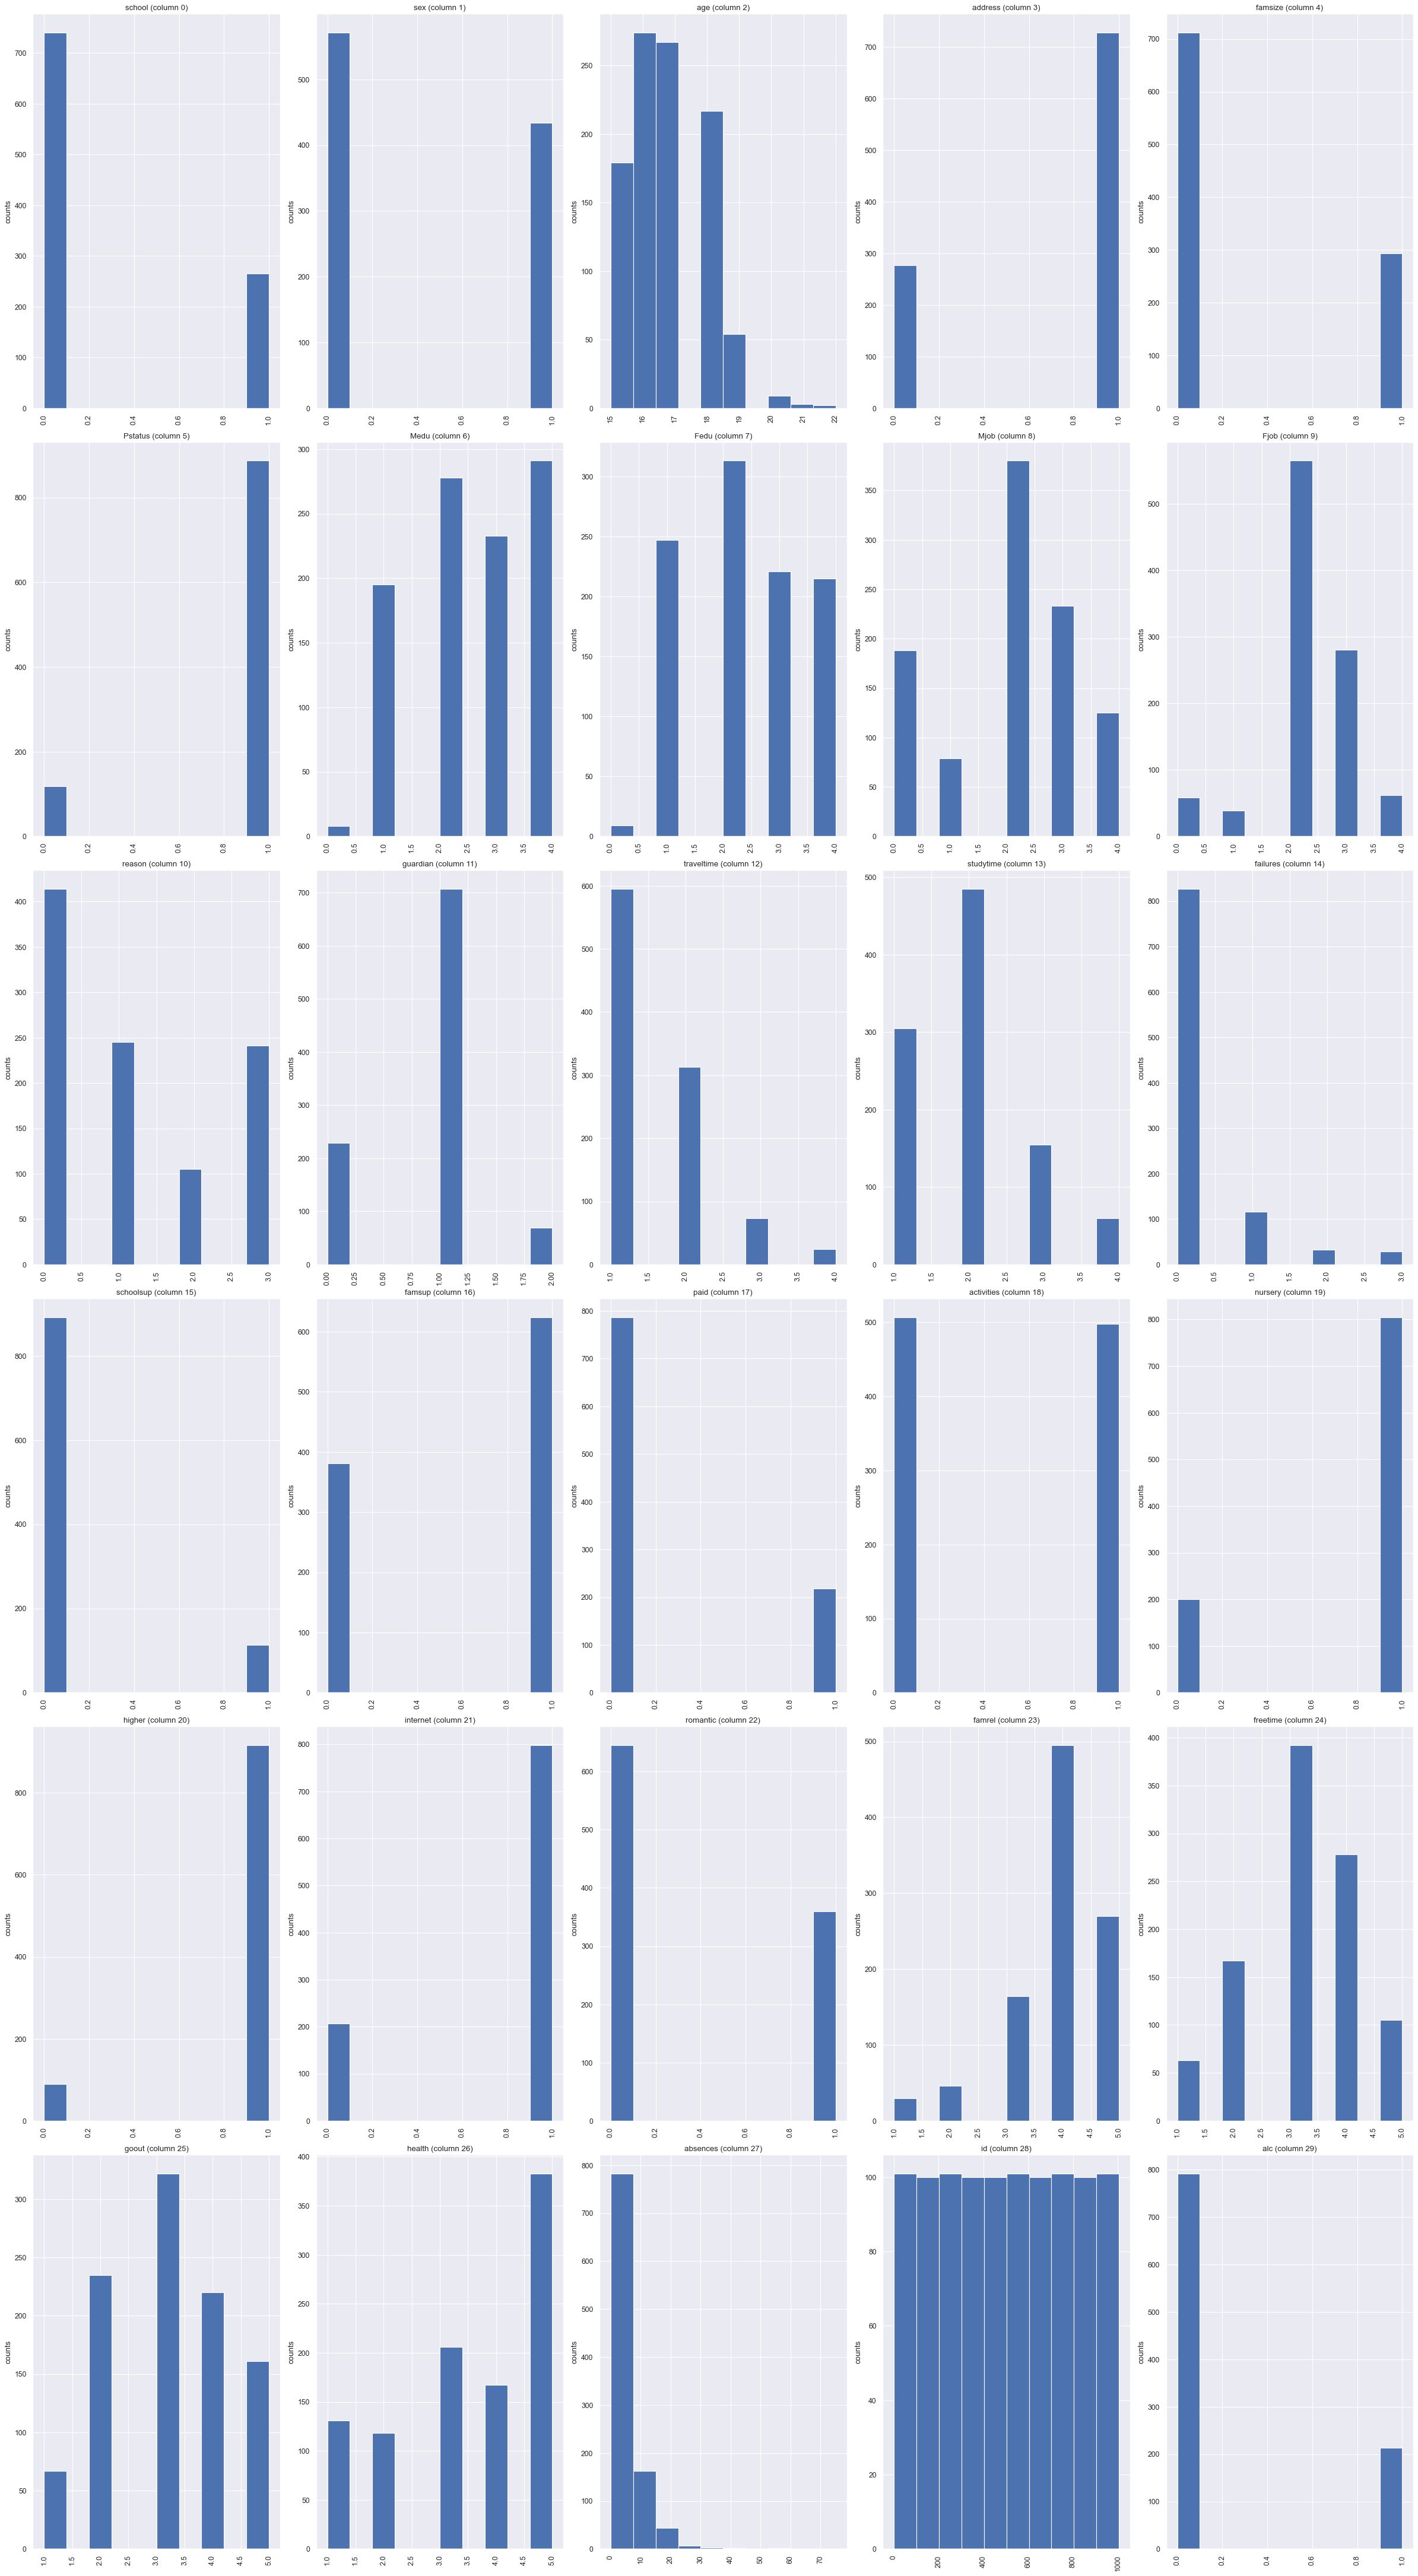

In [64]:
# this function will be used to plot the distribution of data in each column

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

plotPerColumnDistribution(students1, 30, 5)

The above bar charts show us that for each variable, some values have a significantly higher occurence than other values which may lead to bias in the predictions of the models.

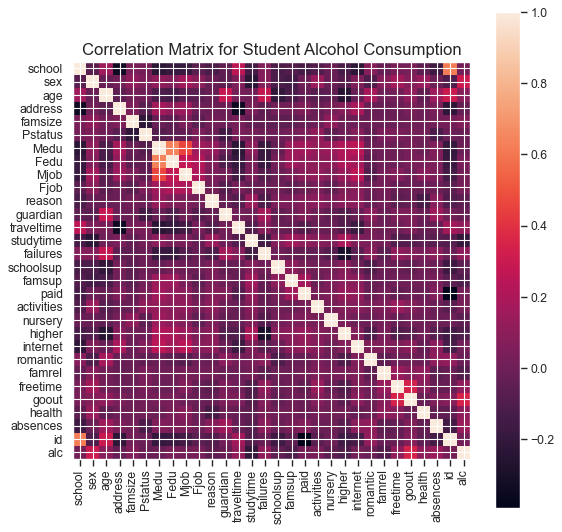

In [65]:
# this function will be used to plot the correlation matrix of the data.
# correlation describes the relationship between numerical variables. this is problematic because we have 
# categorical variables that are 'int' type, which should not be treated as numeric. 
# for the purposes of exploration, we will plot it anyways.

def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for Student Alcohol Consumption', fontsize=15)
    plt.show()

newDF = students1.select_dtypes(include=np.number)
newDF.dataframeName = 'student-mat.csv'
plotCorrelationMatrix(newDF, 8)

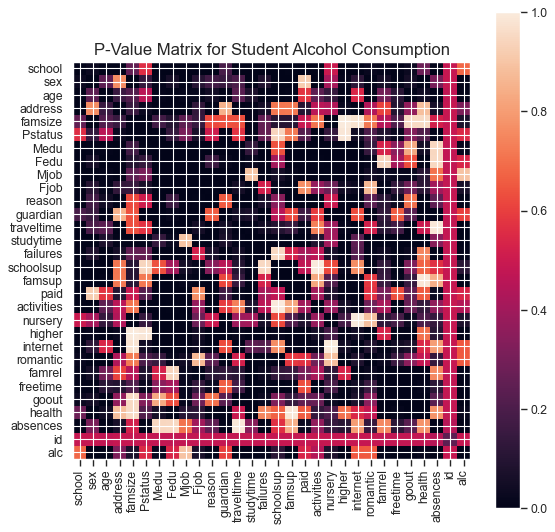

In [66]:
# chi-squared test for independence. this will help us find columns that appear to be dependent so we can group them together
# We used this test to discover the significance of columns as predictors because most of the columns are categorical, 
# and the chi-square test determines the association between categorical variables.
def plotPValueMatrix(df, graphWidth):
    if df.shape[1] < 2:
        print(f'No p-value plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            contingency = pd.crosstab(df[col1], df[col2])
            _, p, _, _ = chi2_contingency(contingency)
            p_values.loc[col1, col2] = p
    p_values = p_values.astype(float)
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    pMat = plt.matshow(p_values, fignum = 1)
    plt.xticks(range(len(p_values.columns)), p_values.columns, rotation=90)
    plt.yticks(range(len(p_values.columns)), p_values.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(pMat)
    plt.title(f'P-Value Matrix for Student Alcohol Consumption', fontsize=15)
    plt.show()

plotPValueMatrix(students1, 8)


Reading Chi-Square Test Results: The Null hypothesis in this case is that the two columns are independent. The Alternative hypothesis is that they are dependent. If the p-value is less than 0.05, we will usually reject the Null hypothesis. In this case, we just want to see the dependence for grouping the variables together.

We can see that the alcohol column 'alc' has varying p-values with each column. We will examine that deeper in a next step. For now, we will just group the columns that are not 'id' and 'alc'.

In [67]:
# we decided these groupings using our descretion and the p-value matrix above.
# columns that seem to be dependent are grouped together.
fam_columns = ['famrel', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian', 'famsup', 'address']
education_columns = ['Medu', 'Fedu', 'failures', 'schoolsup', 'studytime', 'paid', 'nursery', 'higher', 'reason', 'school', 'activities']
char_columns = ['age', 'health', 'sex']
lifestyle_columns = ['traveltime', 'absences', 'freetime', 'goout', 'internet', 'romantic']

family = students1[fam_columns].copy()
education = students1[education_columns].copy()
char = students1[char_columns].copy()
lifestyle = students1[lifestyle_columns].copy()

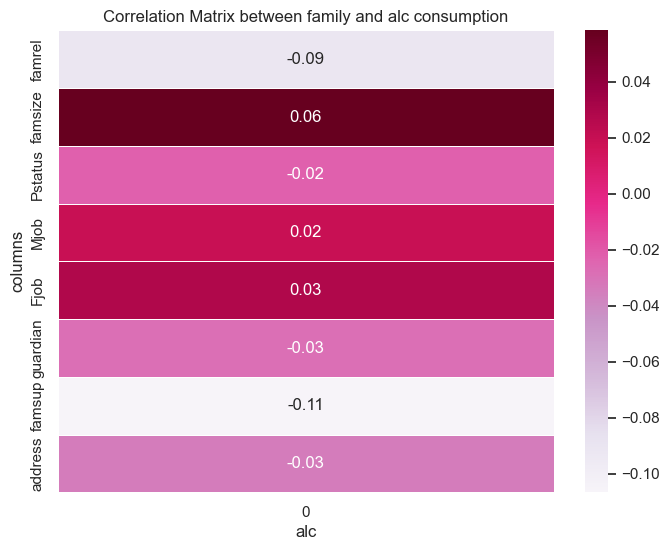

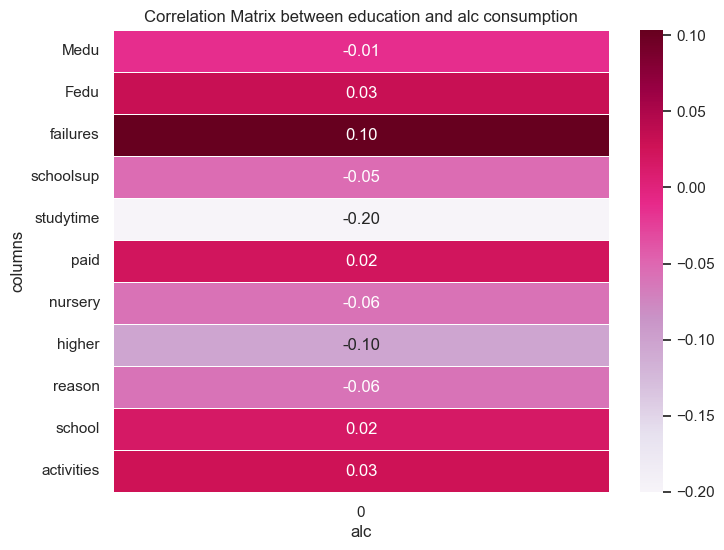

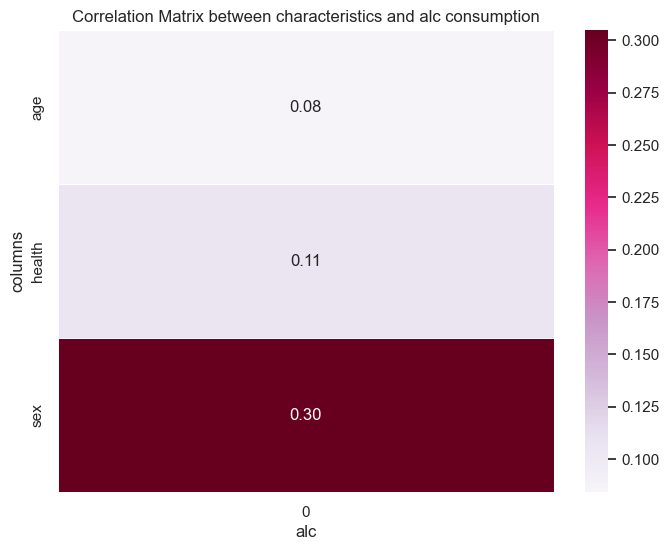

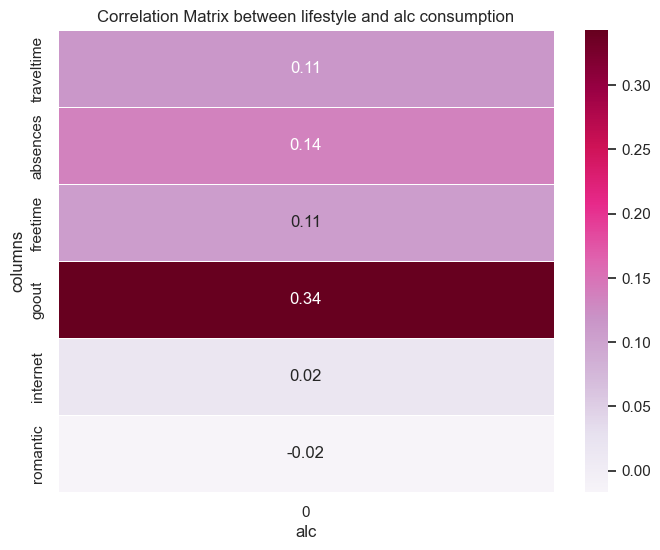

In [68]:
# extract the alcohol column 
alcohol_consumption = students1['alc']

# FAMILY
# calculate correlation coefficients
correlation_matrix = family.corrwith(alcohol_consumption)

# plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='PuRd', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix between family and alc consumption")
plt.xlabel("alc")
plt.ylabel("columns")
plt.show()

# EDUCATION
# calculate correlation coefficients
correlation_matrix = education.corrwith(alcohol_consumption)

# plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='PuRd', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix between education and alc consumption")
plt.xlabel("alc")
plt.ylabel("columns")
plt.show()

# CHAR
# calculate correlation coefficients
correlation_matrix = char.corrwith(alcohol_consumption)

# plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='PuRd', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix between characteristics and alc consumption")
plt.xlabel("alc")
plt.ylabel("columns")
plt.show()

# LIFESTYLE
# calculate correlation coefficients
correlation_matrix = lifestyle.corrwith(alcohol_consumption)

# plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='PuRd', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix between lifestyle and alc consumption")
plt.xlabel("alc")
plt.ylabel("columns")
plt.show()

For school against alcohol consumption, the p-value is 0.6824192929728525 and hence we accept the null hypothesis with 1 degrees of freedom

For sex against alcohol consumption, the p-value is 9.160676916814838e-22 and hence we reject the null hypothesis with 1 degrees of freedom

For age against alcohol consumption, the p-value is 0.006069051034598225 and hence we reject the null hypothesis with 7 degrees of freedom

For address against alcohol consumption, the p-value is 0.3170208235612169 and hence we accept the null hypothesis with 1 degrees of freedom

For famsize against alcohol consumption, the p-value is 0.07730865181355791 and hence we accept the null hypothesis with 1 degrees of freedom

For Pstatus against alcohol consumption, the p-value is 0.5503227980195815 and hence we accept the null hypothesis with 1 degrees of freedom

For Medu against alcohol consumption, the p-value is 0.019611518148401307 and hence we reject the null hypothesis with 4 degrees of freedom

For Fedu a

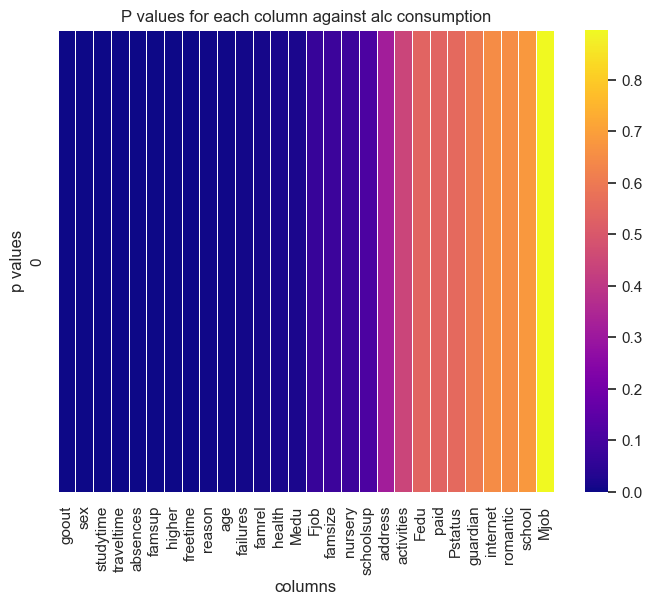

In [69]:
# extract the alcohol column 
alcohol_consumption = students1['alc']

# define subsets of your data
data_subsets = {'FAMILY': family, 'EDUCATION': education, 'CHAR': char, 'LIFESTYLE': lifestyle}

# use a loop to plot correlation with alc
# the chi-square test is a test of independence between two variables in a contingency table (cross tab) 
# the null hypothesis is that the two variables are independent, and the alternative hypothesis is that they are dependent 
# the test statistic is the sum of the squared differences between the observed and expected frequencies in all cells of the table
pValues = {}
cols = list(students1.columns)
for col in cols:
    if col in ['id', 'alc']:
        continue
    cross_tab = pd.crosstab(index=students1[col], columns=students1['alc']) 
    chi_sq_result = chi2_contingency(cross_tab) # this is the chi square test
    p, x = chi_sq_result[1], "reject" if chi_sq_result[1] < 0.05 else "accept"
    # best p values and columns
    if p < 0.01:
        print(f"For {col} against alcohol consumption, the p-value is {chi_sq_result[1]} and hence we {x} the null hypothesis with {chi_sq_result[2]} degrees of freedom\n")
    else:
        print(f"For {col} against alcohol consumption, the p-value is {chi_sq_result[1]} and hence we {x} the null hypothesis with {chi_sq_result[2]} degrees of freedom\n")
    # store p values in a dictionary
    pValues[col] = p

# plot p values in a heatmap
# sort the columns based on the p values (most significant to least significant)
pValues = {k: v for k, v in sorted(pValues.items(), key=lambda item: item[1])}
plt.figure(figsize=(8, 6))
sb.heatmap(pd.DataFrame(pValues, index=[0]), annot=False, cmap='plasma', fmt=".2f", linewidths=.5)
plt.title("P values for each column against alc consumption")
plt.xlabel("columns")
plt.ylabel("p values")
plt.show()


# K-Nearest Neighbours

This algorithm is a  non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point.
We chose it because most of the columns we are using as predictors are categorical, so using a classifier by clustering made more sense than any other type of model.

It is a simple model that classifies the data into two classes 0 (low alcohol consumption) and 1 (high alcohol consumption) based on the number of nearest neighbours. The decision boundary is displayed to show the classification.


In [70]:
clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

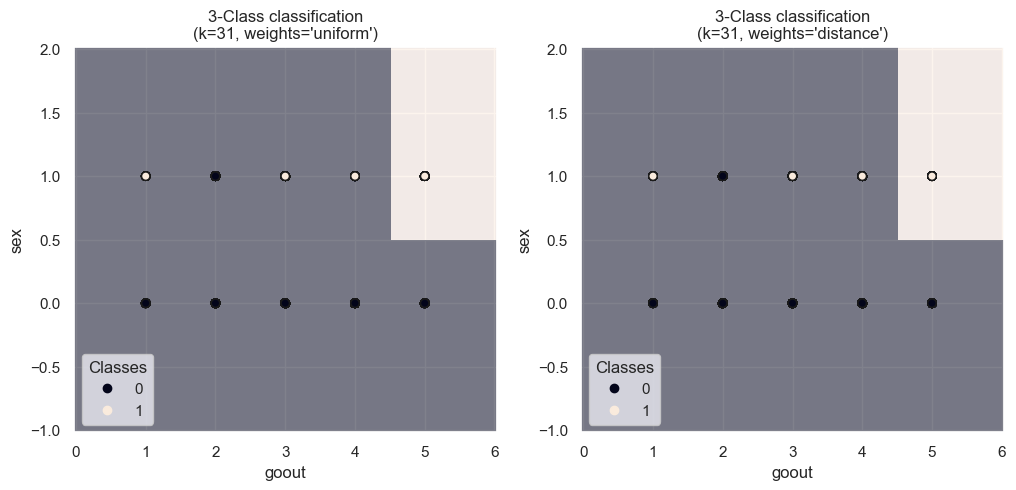

In [71]:
X = students1[["goout", "sex"]]
y = students1['alc']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0) # default split: 75:25

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=31))] # use 31 neighbours first because it is the square root of the number of samples
)

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")): # uniform and distance are the two types of weights
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        students1['alc'].unique(),
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()


Best cross-validation score: 0.84
Best parameters: {'knn__n_neighbors': 41}


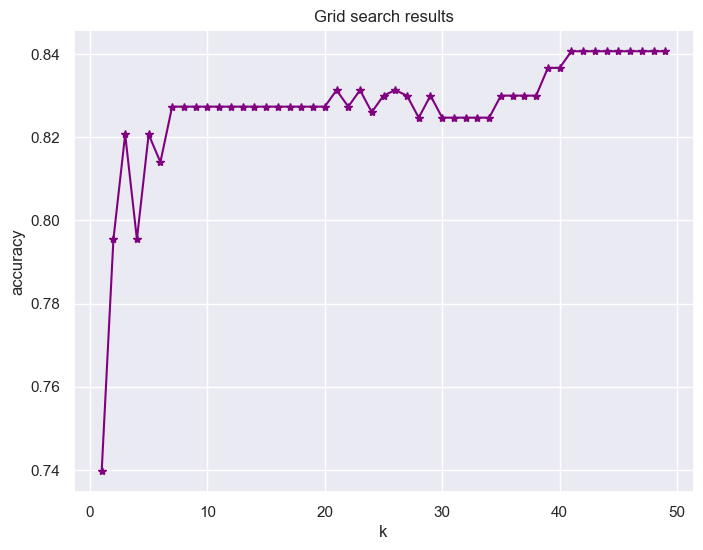

In [72]:
# find the best k-value before training the model

param_grid = {"knn__n_neighbors": np.arange(1, 50)}
grid = GridSearchCV(clf, param_grid, cv=5) # 5-fold cross-validation. GridSearchCV finds the best k value for the model
grid.fit(X_train, y_train)

print(f"Best cross-validation score: {grid.best_score_:.2f}") # accuracy of the model
print(f"Best parameters: {grid.best_params_}") # best k-value

# plot the best k-value
plt.figure(figsize=(8, 6))
plt.plot(grid.cv_results_["param_knn__n_neighbors"], grid.cv_results_["mean_test_score"], marker="*", color="purple")
plt.title("Grid search results")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

In [73]:
# using different sets of predictors to find the best and worst predictors

list1 = [lifestyle_columns, char_columns, education_columns, fam_columns]

for i in range(len(list1)):
    X = students1[list1[i]]
    y = students1['alc']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    clf = Pipeline(
        steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=41))] # use the best k-value from the previous step
    )

    print(f"Using columns: {list1[i]}")
    clf.fit(X_train, y_train)
    print(f"Train score: {clf.score(X_train, y_train)}")
    print(f"Test score: {clf.score(X_test, y_test)}")
    print("")



Using columns: ['traveltime', 'absences', 'freetime', 'goout', 'internet', 'romantic']
Train score: 0.7928286852589641
Test score: 0.7896825396825397

Using columns: ['age', 'health', 'sex']
Train score: 0.7901726427622842
Test score: 0.7579365079365079

Using columns: ['Medu', 'Fedu', 'failures', 'schoolsup', 'studytime', 'paid', 'nursery', 'higher', 'reason', 'school', 'activities']
Train score: 0.7875166002656042
Test score: 0.7896825396825397

Using columns: ['famrel', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian', 'famsup', 'address']
Train score: 0.7875166002656042
Test score: 0.7896825396825397



Using the best K-value we got, the best accuracy we got in predicting alcohol consumption was 78.9% using every type of predictor except for the 'character' variables. This tells us that things like age, health status and gender do not predict alcohol consumption well. 

The other sets variables are equally good for predicting.

How we can use this information: In the future, we can remove the 'character' variables and leave the other columns to get a better model accuracy.

In [74]:
X = students1.drop(columns=['alc', 'id', 'age', 'health', 'sex'])
y = students1['alc']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=41))] # use the best k-value from the previous step
)

clf.fit(X_train, y_train)
print(f"Train score: {clf.score(X_train, y_train)}")
print(f"Test score: {clf.score(X_test, y_test)}")

Train score: 0.7875166002656042
Test score: 0.7896825396825397


This gives us our final K-Nearest Neighbours model accuracy of 78.9%.

# SVM Modelling

Compared to K-Nearest Neighbours, Support Vector Machine handles inbalanced data well as it simply finds the optimal hyperplane that separates the classes in the feature space (the data). 'Optimal' refers to the largest margin between the decision boundary (the hyperplane) and its closest data points (support vectors) from each class.

Because SVMs only consider the support vectors, not the entire dataset like KNN does, it has a chance of being more accurate.

We take the following steps to find the best set of predictor columns:

1. Get model accuracy using all columns

2. Compare the model accuracies with each set of columns other than the 'character' set, because that set performed the worst in the KNN model.

In [85]:
# SVM using different sets of predictors

list1 = [lifestyle_columns, education_columns, fam_columns]

for i in range(len(list1)):
    features = students1[list1[i]] # Extract features 
    target = students1['alc'] # Define the target variable 'alc'
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42) # Default split 75:25

    # Feature scaling
    scaler = StandardScaler() # Initialize StandardScaler
    X_train_scaled = scaler.fit_transform(X_train) # Fit and transform training features
    X_test_scaled = scaler.transform(X_test) # Transform testing features using the same scaler

    # Initialize SVM classifier
    svm_classifier = SVC(kernel='rbf', random_state=42) 

    # Train the SVM model
    svm_classifier.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = svm_classifier.predict(X_test_scaled)

    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    print("Accuracy using columns {} is: {:.2f}".format(list1[i], accuracy)) # Print accuracy

    # More detailed evaluation
    print(classification_report(y_test, y_pred)) # Generate classification report

    precision = metrics.precision_score(y_test, y_pred)
    print("Precision: ", precision) # OVERALL precision

    print("")

Accuracy using columns ['traveltime', 'absences', 'freetime', 'goout', 'internet', 'romantic'] is: 0.79
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       194
           1       0.69      0.16      0.25        58

    accuracy                           0.79       252
   macro avg       0.74      0.57      0.57       252
weighted avg       0.77      0.79      0.73       252

Precision:  0.6923076923076923

Accuracy using columns ['Medu', 'Fedu', 'failures', 'schoolsup', 'studytime', 'paid', 'nursery', 'higher', 'reason', 'school', 'activities'] is: 0.77
              precision    recall  f1-score   support

           0       0.77      0.99      0.87       194
           1       0.50      0.02      0.03        58

    accuracy                           0.77       252
   macro avg       0.64      0.51      0.45       252
weighted avg       0.71      0.77      0.68       252

Precision:  0.5

Accuracy using columns ['famrel', 'famsize'

c:\Users\ishaj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ishaj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ishaj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ishaj\anaconda3\Lib\site-packages\sklearn\metr

In [81]:
features = students1.drop(columns=['alc', 'id', 'age', 'sex', 'health']) # Extract features by removing the target variable 'alc'
target = students1['alc'] # Define the target variable 'alc'

# Encode categorical variables
categorical_cols = features.select_dtypes(include=['object']).columns # Identify categorical columns
label_encoders = {} # Initialize dictionary to store label encoders for each categorical column
for col in categorical_cols:
    label_encoders[col] = LabelEncoder() # Initialize label encoder for each categorical column
    features[col] = label_encoders[col].fit_transform(features[col]) # Encode categorical column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42) # Default split 75:25

# Feature scaling
scaler = StandardScaler() # Initialize StandardScaler
X_train_scaled = scaler.fit_transform(X_train) # Fit and transform training features
X_test_scaled = scaler.transform(X_test) # Transform testing features using the same scaler

# Initialize SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42) 

# Train the SVM model
svm_classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred = svm_classifier.predict(X_test_scaled)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
print("Accuracy:", accuracy)

# More detailed evaluation
print(classification_report(y_test, y_pred)) # Generate classification report

precision = metrics.precision_score(y_test, y_pred)
print("Precision: ", precision) # OVERALL precision

Accuracy: 0.7810945273631841
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       149
           1       1.00      0.15      0.27        52

    accuracy                           0.78       201
   macro avg       0.89      0.58      0.57       201
weighted avg       0.83      0.78      0.71       201

Precision:  1.0


What these results mean

- Precision = Accuracy of poistive predictions
- 96% of the instances predicted as not consuming alcohol were actually not consuming alcohol.
-  98% of the instances predicted as consuming alcohol were actually consuming alcohol.

-Recall = the ability of the model to correctly identify positive instances.
        = True Positives / (True Positives + False Negatives)
- 99% of the actual instances of not consuming alcohol were correctly predicted by the model.
- 88% of the actual instances of consuming alcohol were correctly predicted by the model.

# Gaussian Naive Bayes

This classification algorithm ...

In [76]:
# Import the train_test_split function from the scikit-learn library to divide data into training and test sets.
from sklearn.model_selection import train_test_split
# Import the GaussianNB classifier from the scikit-learn library which implements the Gaussian Naive Bayes algorithm.
from sklearn.naive_bayes import GaussianNB
# Import the accuracy_score function from scikit-learn to compute the accuracy of our model predictions.
from sklearn.metrics import accuracy_score

# Drop the column 'alc' from the DataFrame 'students1' and assign the resulting DataFrame to 'X'.
# This DataFrame 'X' now contains only the features that will be used to predict the target variable.
X = students1.drop(columns=['alc'])
# Assign the column 'alc' from the DataFrame 'students' to 'y'. This series 'y' contains the target variable.
y = students['alc']

# Use the train_test_split function to split 'X' and 'y' into training and test sets.
# 30% of the data is allocated to the test set ('test_size=0.3') and the split is reproducible ('random_state=42').
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create an instance of the GaussianNB class. This instance 'gnb' is the classifier that will be trained.
gnb = GaussianNB()

# Fit the Gaussian Naive Bayes classifier 'gnb' on the training data 'X_train' and 'y_train'.
gnb.fit(X_train, y_train)

# Use the trained classifier 'gnb' to make predictions on the test data 'X_test'.
y_pred = gnb.predict(X_test)

# Calculate the accuracy of the predictions 'y_pred' by comparing them with the actual labels 'y_test'.
accuracy = accuracy_score(y_test, y_pred)
# Print the computed accuracy.
print(f"Accuracy: {accuracy}")

# Print the predictions made on the test data.
print("Predictions:", y_pred)

# Iterate over the actual labels and predicted labels, and print each pair.
for actual, predicted in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Calculate the number of correct predictions by comparing the predicted labels 'y_pred' directly with 'y_test'.
correct_predictions = np.sum(y_pred == y_test)
# Calculate the number of incorrect predictions by checking where 'y_pred' does not equal 'y_test'.
wrong_predictions = np.sum(y_pred != y_test)

# Print the number of correct predictions.
print(f"Correct Predictions: {correct_predictions}")
# Print the number of wrong predictions.
print(f"Wrong Predictions: {wrong_predictions}")

# Retrieve the list of predictor variables from the DataFrame 'X' and print them.
predictor_variables = X.columns.tolist()
print("Predictor Variables:", predictor_variables)


Accuracy: 0.7582781456953642
Predictions: [1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Actual: 0, Predicted: 1
Actual: 0, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 1
Actual: 0, Predicted: 1
Actual: 1, Predicted: 0
Actual: 1, Predicted: 0
Actual: 

- The output tells us the accuracy using the number of correct predictions divided by the total number of predictions made.
- These are instances where the model's predicted value (output) matches the actual value from the data.
- For example, if the actual label for a student's alcohol consumption is 0 (not consuming alcohol above a certain threshold) and the model also predicts 0, this is counted as a correct prediction.
- Similarly, if the actual label is 1 (consuming alcohol above the threshold) and the prediction is also 1, this is also a correct prediction.
- Correct predictions contribute positively to the model's accuracy and indicate that the model has effectively learned the underlying patterns

# References

dataset: https://www.kaggle.com/datasets/uciml/student-alcohol-consumption
- pandas documentation
- sklearn documentation
- https://www.ibm.com/topics/knn
- https://www.shiksha.com/online-courses/articles/handling-categorical-variables-with-one-hot-encoding/
- https://www.stratascratch.com/blog/chi-square-test-in-python-a-technical-guide/
- https://www.kaggle.com/code/melihkanbay/knn-best-parameters-gridsearchcv
- 